In [1]:
from data import wiki
from data import corpus
import alignment

import nltk
import pandas as pd
import pickle
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

posts = wiki.load_posts()
users = wiki.load_users(posts=posts)

markers = alignment.load_markers()

In [2]:
posts['post_len'] = posts['tokens'].apply(len) # length of 'b' posts

for m in markers: # binary marker presence
    posts[m+'_bin'] = posts[m] > 0

# set up dataframe of reply pairs (a,b) 
pairs = corpus.get_reply_pairs(posts)
df = pairs\
    .merge(users.add_suffix('_a'), how='left', left_on='user_a', right_index=True)\
    .merge(users.add_suffix('_b'), how='left', left_on='user_b', right_index=True)

In [3]:
# compute condintions for alignment measurement
centrality_threshold = users.centrality.mean() + users.centrality.std()
df['highly_central_a'] = df.centrality_a > centrality_threshold
df['admin_at_time_a'] = df.timestamp_b > df.admin_ascension_a

# compute overall marker frequency for measure scaling/normalization
marker_freq = dict(posts[list(markers)].sum() / posts['post_len'].sum())

In [4]:
def scp(a):
    """ `a` is a dataframe containing reply pairs where user_a is a member
        of the desired group A.
        `marker_freq` is a dictionary from markers to overall frequencies
        in the whole corpus.
    """
    def scp_m(m):

        # TODO: implement bootstrap resampling for confidence?

        base_prob = a.groupby('user_b')[m+'_bin_b'].mean()
        cond_prob = a[a[m+'_bin_a']].groupby('user_b')[m+'_bin_b'].mean()
        
        return cond_prob - base_prob

    return pd.DataFrame({m: scp_m(m) for m in markers})

In [5]:
def wscp(a):
    """ `a` is a dataframe containing reply pairs where user_a is a member
        of the desired group A.
        `marker_freq` is a dictionary from markers to overall frequencies
        in the whole corpus.
    """
    def wscp_m(m):

        base_m_count = a.groupby('user_b')[m+'_b'].sum()
        base_word_count = a.groupby('user_b')['post_len_b'].sum()
        base_prob = base_m_count / base_word_count

        cond_m_count = a[a[m+'_bin_a']].groupby('user_b')[m+'_b'].sum()
        cond_word_count = a[a[m+'_bin_a']].groupby('user_b')['post_len_b'].sum()
        cond_prob = cond_m_count / cond_word_count
        
        return (cond_prob - base_prob) / marker_freq[m]

    return pd.DataFrame({m: wscp_m(m) for m in markers})


In [6]:
def agg1(df):
    """ Computes "Aggregated 1" as described in Echoes of Power.
        Drop any users missing any of the values.
    """
    return df.dropna().mean(axis=1)

def agg2(df):
    """ Computes "Aggregated 2" as described in Echoes of Power.
        Fill missing values with the group average
    """ 
    return df.fillna(df.mean()).mean(axis=1)

def agg3(df):
    """ Computes "Aggregated 3" as described in Echoes of Power.
        Fill missing values with the per-user mean of the other markers.
    """ 
    return df.transpose().fillna(df.mean(axis=1)).transpose().mean(axis=1)

def coord_with_aggs(coord_measure, a):
    coords = coord_measure(a)
    aggs = pd.Series([agg1(coords).mean(), agg2(coords).mean(), agg3(coords).mean()], index=['agg1', 'agg2', 'agg3'])
    return aggs.append(pd.Series(coords.mean()))

In [11]:
%matplotlib inline

conditions = [
        ('High Centrality Targets', df[df['highly_central_a']]),
        ('Low Centrality Targets', df[~df['highly_central_a']]),
        ('Admin Targets', df[df['admin_at_time_a']]),
        ('Non-Admin Targets', df[~df['admin_at_time_a']])]
labels, dfs = zip(*conditions)

                     High Centrality Targets  Low Centrality Targets  \
agg1                                0.013578                0.014586   
agg2                                0.011057                0.012549   
agg3                                0.009877                0.010882   
adverbs                             0.006879                0.007142   
articles                            0.009897                0.009978   
auxiliary_verbs                     0.010458                0.010256   
conjunctions                        0.008885                0.010459   
impersonal_pronouns                 0.016375                0.018714   
personal_pronouns                   0.008524                0.009559   
prepositions                        0.005762                0.004853   
quantifiers                         0.021673                0.029427   

                     Admin Targets  Non-Admin Targets  
agg1                      0.014199           0.014392  
agg2                   

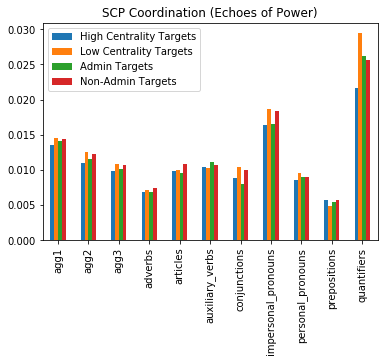

In [12]:
scp_results = pd.DataFrame({group: coord_with_aggs(scp, group_df) for group, group_df in conditions}, columns=labels)
title1="SCP Coordination (Echoes of Power)"
print(scp_results)
scp_results.plot.bar(title=title1)

                     High Centrality Targets  Low Centrality Targets  \
agg1                                0.005320                0.010810   
agg2                                0.002762                0.008535   
agg3                                0.002618                0.006632   
adverbs                             0.001099                0.002854   
articles                            0.000846                0.003830   
auxiliary_verbs                     0.003071                0.003505   
conjunctions                        0.000830                0.001766   
impersonal_pronouns                 0.007035                0.013690   
personal_pronouns                   0.006097                0.012002   
prepositions                        0.001108                0.001341   
quantifiers                         0.002010                0.029294   

                     Admin Targets  Non-Admin Targets  
agg1                      0.008225           0.008217  
agg2                   

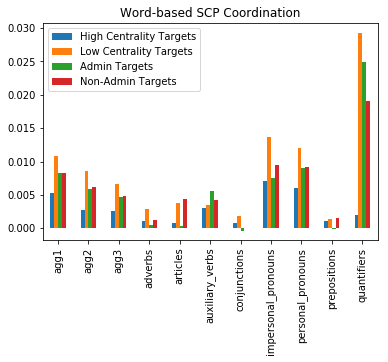

In [13]:
wscp_results = pd.DataFrame({group: coord_with_aggs(wscp, df) for group, df in conditions}, columns=labels)
title2="Word-based SCP Coordination"
print(wscp_results)
wscp_results.plot.bar(title=title2)


In [27]:
' '.join(list(df))

'reply_to utterance_id_a user_a talkpage_user_a conversation_root_a reply_to_a timestamp_a timestamp_unixtime_a clean_text_a raw_text_a tokens_a pos_tags_a conjunctions_a articles_a prepositions_a adverbs_a quantifiers_a impersonal_pronouns_a personal_pronouns_a auxiliary_verbs_a post_len_a adverbs_bin_a conjunctions_bin_a articles_bin_a auxiliary_verbs_bin_a prepositions_bin_a impersonal_pronouns_bin_a personal_pronouns_bin_a quantifiers_bin_a utterance_id_b user_b talkpage_user_b conversation_root_b reply_to_b timestamp_b timestamp_unixtime_b clean_text_b raw_text_b tokens_b pos_tags_b conjunctions_b articles_b prepositions_b adverbs_b quantifiers_b impersonal_pronouns_b personal_pronouns_b auxiliary_verbs_b post_len_b adverbs_bin_b conjunctions_bin_b articles_bin_b auxiliary_verbs_bin_b prepositions_bin_b impersonal_pronouns_bin_b personal_pronouns_bin_b quantifiers_bin_b edit_count_a gender_a numerical_id_a post_count_a admin_ascension_a admin_a centrality_a edit_count_b gender_b n

In [52]:
from collections import Counter, defaultdict

bm_Am = Counter() # count u_b and u_a exhibit m 
bm_A  = Counter() # count u_b exhibits m
b_Am  = Counter() # count u_a exhibits m
b_A = Counter() # count total number of reply pairs (u_b, u_a)
m = 'conjunctions'

In [53]:
for idx, r in tqdm(df.iterrows(), total=len(df)):
    if r['admin_at_time_a']:
        b_A[r['user_b']] += 1
    else:
        continue
    if r[m+'_bin_a']:
        b_Am[r['user_b']] += 1
        if r[m+'_bin_b']:
            bm_Am[r['user_b']] += 1
    if r[m+'_bin_b']:
        bm_A[r['user_b']] += 1

In [54]:
import numpy as np

scp_user = {}
for user in b_A:
    if b_A[user] == 0 or b_Am[user] == 0:
        continue
    scp_user[user] = (bm_Am[user] / b_Am[user]) - (bm_A[user] / b_A[user]) 

In [55]:
sum(scp_user.values()) / len(scp_user)

0.007998495474840677

In [57]:
bm_Am = Counter() # count u_b and u_a exhibit m 
bm_A  = Counter() # count u_b exhibits m
b_Am  = Counter() # count u_a exhibits m
b_A = Counter() # count total number of reply pairs (u_b, u_a)

m = 'conjunctions'

for idx, r in tqdm(df.iterrows(), total=len(df)):
    if not r['admin_at_time_a']:
        b_A[r['user_b']] += 1
    else:
        continue
    if r[m+'_bin_a']:
        b_Am[r['user_b']] += 1
        if r[m+'_bin_b']:
            bm_Am[r['user_b']] += 1
    if r[m+'_bin_b']:
        bm_A[r['user_b']] += 1
        
scp_user = {}
for user in b_A:
    if b_A[user] == 0 or b_Am[user] == 0:
        continue
    scp_user[user] = (bm_Am[user] / b_Am[user]) - (bm_A[user] / b_A[user]) 
    
sum(scp_user.values()) / len(scp_user)

0.009990430417021754

In [50]:
df.admin_at_time_a.value_counts()

False    130622
True     42141 
Name: admin_at_time_a, dtype: int64

In [60]:
len(df['user_b'].unique())

15099

In [72]:
def div_safe(arr):
    arr[arr == 0] = np.nan
    return arr

def get_coordination(groupA_cond):
    
    B = df['user_b'].unique()
    B_to_index = {b: i for i, b in enumerate(B)}

    # coordination given counts - counting over pairs 
    # (u_a, u_b) where a in A said u_a and b replied with u_b
    Am_bm = np.zeros((len(markers), len(B))) # defaultdict(Counter) # count u_a and u_b exhibit m 
    Am_b  = np.zeros((len(markers), len(B))) # defaultdict(Counter) # count u_a exhibits m
    A_bm  = np.zeros((len(markers), len(B))) # defaultdict(Counter) # count u_b exhibits m
    A_b   = np.zeros((len(B),)) # count total number of reply pairs (u_a, u_b)

    # coordination received counts - counting over pairs
    # (u_b, u_a) where b said u_b and a in A replied with u_a
    bm_Am = np.zeros((len(markers), len(B))) # defaultdict(Counter) # count u_b and u_a exhibit m 
    bm_A  = np.zeros((len(markers), len(B))) # defaultdict(Counter) # count u_b exhibits m
    b_Am  = np.zeros((len(markers), len(B))) # defaultdict(Counter) # count u_a exhibits m
    b_A   = np.zeros((len(B),)) # Counter() # count total number of reply pairs (u_b, u_a)

    # count marker occurances & instances of alignment among reply pairs
    print("Gathering marker counts...")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        reply_user = row['user_b']
        parent_user = row['user_a']

        # increment coordination given counts
        if groupA_cond(row):
            b_i = B_to_index[reply_user]
            A_b[b_i] += 1
            for m_i, m in enumerate(markers):
                if row[m+'_bin_a']:  #if parent.exhibits_marker(m):
                    Am_b[m_i,b_i] += 1
                    if row[m+'_bin_b']: #if reply.exhibits_marker(m):
                        Am_bm[m_i,b_i] += 1
                if row[m+'_bin_b']: #if reply.exhibits_marker(m):
                    A_bm[m_i,b_i] += 1

        # increment coordination received counts
#         if reply_user in A and parent_user in B: 
#             b_i = B_to_index[parent_user]
#             b_A[b_i] += 1
#             for m_i, m in enumerate(marker_list):
#                 if parent.exhibits_marker(m):
#                     bm_A[m_i,b_i] += 1
#                     if reply.exhibits_marker(m):
#                         bm_Am[m_i,b_i] += 1
#                 if reply.exhibits_marker(m):
#                     b_Am[m_i,b_i] += 1

    # calculate the per-marker coordinations
    coord_given = (Am_bm / div_safe(Am_b)) - (A_bm / div_safe(A_b))
#     coord_received = (bm_Am / div_safe(bm_A)) - (b_Am / div_safe(b_A))

    # calculate the aggrigate (ignoring undefined markers its undefined for)
    coord_given_agg3 = np.nanmean(coord_given, axis=0)
#     coord_received_agg3 = np.nanmean(coord_received, axis=0)

    # convert back to dictionary output
    coord_given = {m: {b: coord_given[m_i,b_i] 
        for b_i, b in enumerate(B)} for m_i, m in enumerate(markers)}
#     coord_received = {m: {b: coord_received[m_i,b_i] 
#         for b_i, b in enumerate(B)} for m_i, m in enumerate(marker_list)}

    for b in tqdm(B):
        coord_given['agg3'] = {b: coord_given_agg3[b_i] for b_i, b in enumerate(B)} 
#         coord_received['agg3'] = {b: coord_received_agg3[b_i] for b_i, b in enumerate(B)} 

    return coord_given #, coord_received


In [73]:
coord_given_admin = get_coordination(lambda x: x['admin_at_time_a'])

Gathering marker counts...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


In [74]:
coord_given_nadmin = get_coordination(lambda x: not x['admin_at_time_a'])

Gathering marker counts...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


In [79]:
for m in markers:
    coord = [c for c in coord_given_admin[m].values() if not np.isnan(c)]
    print('{} : {}'.format(m, sum(coord) / len(coord)))

adverbs : 0.006841871763755899
conjunctions : 0.007998495474840658
articles : 0.009595826005169865
auxiliary_verbs : 0.011136286156910187
prepositions : 0.0054222839561824466
impersonal_pronouns : 0.01655910175818639
personal_pronouns : 0.009001174689171257
quantifiers : 0.02627602457030471


In [80]:
for m in markers:
    coord = [c for c in coord_given_nadmin[m].values() if not np.isnan(c)]
    print('{} : {}'.format(m, sum(coord) / len(coord)))

adverbs : 0.007497042160427875
conjunctions : 0.009990430417021749
articles : 0.010859928313259342
auxiliary_verbs : 0.010703820877890062
prepositions : 0.005806652145838205
impersonal_pronouns : 0.0183899143532242
personal_pronouns : 0.0090257789972184
quantifiers : 0.02564136649824962
